In [1]:
import random
import collections
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import matplotlib.gridspec as grd
import pandas as pd
import time
import itertools

from distancematrix.calculator import AnytimeCalculator
from distancematrix.generator import ZNormEuclidean
from distancematrix.generator.filter_generator import FilterGenerator
from distancematrix.consumer import MatrixProfileLR
from distancematrix.consumer import ContextualMatrixProfile
from distancematrix.consumer.contextmanager import GeneralStaticManager
from distancematrix.insights import lowest_value_idxs
from distancematrix.insights import highest_value_idxs
from distancematrix.math_tricks import sliding_mean_std
from distancematrix.insights import highest_value_idxs

In [2]:
# Read data for 3 ventilation units, each unit measures CO2 content at 15 minute intervals.
data = [
    pd.read_csv("ventilation0.csv", index_col=0, header=None, parse_dates=[0], names=["Time", "CO2"]).iloc[:,0],
    pd.read_csv("ventilation1.csv", index_col=0, header=None, parse_dates=[0], names=["Time", "CO2"]).iloc[:,0],
    pd.read_csv("ventilation2.csv", index_col=0, header=None, parse_dates=[0], names=["Time", "CO2"]).iloc[:,0]
]

# List of daily dates
data_days = data[0].index[::4*24]

# Boolean arrays indicating whether a day is weekend/weekday
weekdays = np.array([d in range(0,5) for d in data_days.dayofweek])
weekends = np.array([d in range(5,7) for d in data_days.dayofweek])

In [3]:
print("Data[0] goes from ", data[0].index[0], "to", data[0].index[-1])
print("Data[1] goes from ", data[1].index[0], "to", data[1].index[-1])
print("Data[2] goes from ", data[2].index[0], "to", data[2].index[-1])

Data[0] goes from  2017-12-01 00:00:00 to 2018-03-31 23:45:00
Data[1] goes from  2017-12-01 00:00:00 to 2018-03-31 23:45:00
Data[2] goes from  2017-12-01 00:00:00 to 2018-03-31 23:45:00


In [4]:
def znorm(serie):
    return (serie - np.mean(serie)) / np.std(serie)

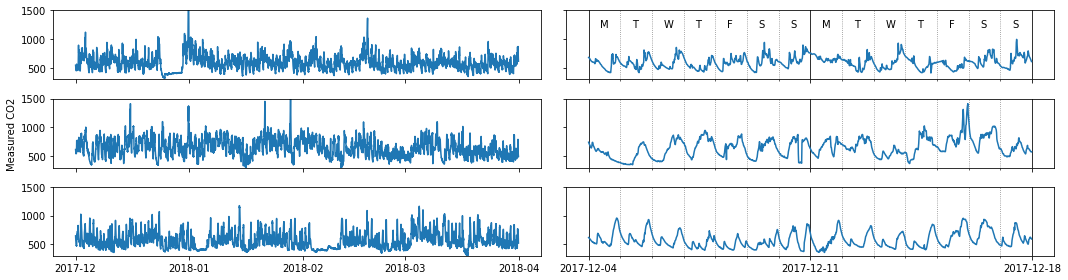

In [5]:
# Plot some extracts of the data
plot_offset = 4*24*3 # skip 3 days, so the plot starts on a Monday

fig, ax = plt.subplots(3,2,sharex='col', sharey=True, figsize=(15,4), gridspec_kw = {'width_ratios':[2, 2]})
ax[0, 0].plot(data[0])
ax[1, 0].plot(data[1])
ax[2, 0].plot(data[2])

ax[0, 1].plot(data[0].iloc[plot_offset:plot_offset+4*24*14])
ax[1, 1].plot(data[1].iloc[plot_offset:plot_offset+4*24*14])
ax[2, 1].plot(data[2].iloc[plot_offset:plot_offset+4*24*14])

ax[0,1].grid(b=True, axis="x", which='minor', color='gray', linestyle=':')
ax[1,1].grid(b=True, axis="x", which='minor', color='gray', linestyle=':')
ax[2,1].grid(b=True, axis="x", which='minor', color='gray', linestyle=':')
ax[0,1].grid(b=True, axis="x", which='major', color='black', linestyle='-')
ax[1,1].grid(b=True, axis="x", which='major', color='black', linestyle='-')
ax[2,1].grid(b=True, axis="x", which='major', color='black', linestyle='-')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax[0,1].xaxis.set_major_locator(mdates.DayLocator([4, 11, 18]))
ax[0,1].xaxis.set_minor_locator(mdates.DayLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,0].set_ylabel("Measured CO2")


for i in data[0].index[4*9+plot_offset:4*24*14+1+plot_offset:4*24]:
    ax[0,1].text(i, 1200, i.day_name()[:1])

ax[0,0].set_ylim(300,1500)
plt.tight_layout()


# plt.savefig("ventilation.pdf", dpi=300, bbox_inches='tight')

In [6]:
# Setup calculation of Matrix Profile and Contextual Matrix Profile for all datasets.

m = 4*3  # 3 hours

context_morning = GeneralStaticManager(
    [range(x*96 + 24, (x*96)+24+8) for x in range(11616//96)] # daily from 6u-8u
)

context_noon = GeneralStaticManager(
    [range(x*96 + 44, (x*96)+44+8) for x in range(11616//96)] # daily from 11u-13u
)

context_evening = GeneralStaticManager(
    [range(x*96 + 68, (x*96)+68+8) for x in range(11616//96)] # daily from 17u-19u
)

calcs = []
cmps_morning = []
cmps_noon = []
cmps_evening = []
mps = []

for i in range(3):
    calc = AnytimeCalculator(m, data[i].values)
    calcs.append(calc)
    
    calc.add_generator(0, FilterGenerator(ZNormEuclidean()))  # Use ZNormed Euclidean as distance metric
    
    # Configure 3 CMP calculations
    cmps_morning.append(calc.add_consumer([0], ContextualMatrixProfile(context_morning)))
    cmps_noon.append(calc.add_consumer([0], ContextualMatrixProfile(context_noon)))
    cmps_evening.append(calc.add_consumer([0], ContextualMatrixProfile(context_evening)))
    
    # Configure MP calculation
    mps.append(calc.add_consumer([0], MatrixProfileLR()))

In [7]:
%%time

# Calculate for all datasets.
for calc in calcs:
    calc.calculate_columns(print_progress=True)

99.991%        0.0 secWall time: 41.9 s


In [8]:
def nan_diag(matrix):
    """
    Fills the diagonal of the passed square matrix with nans.
    """
    
    h, w = matrix.shape
    
    if h != w:
        raise RuntimeError("Matrix is not square")
    
    matrix = matrix.copy()
    matrix[range(h), range(w)] = np.nan
    return matrix    

Text(0.5, 1.0, 'Ventilation CMP (evening)')

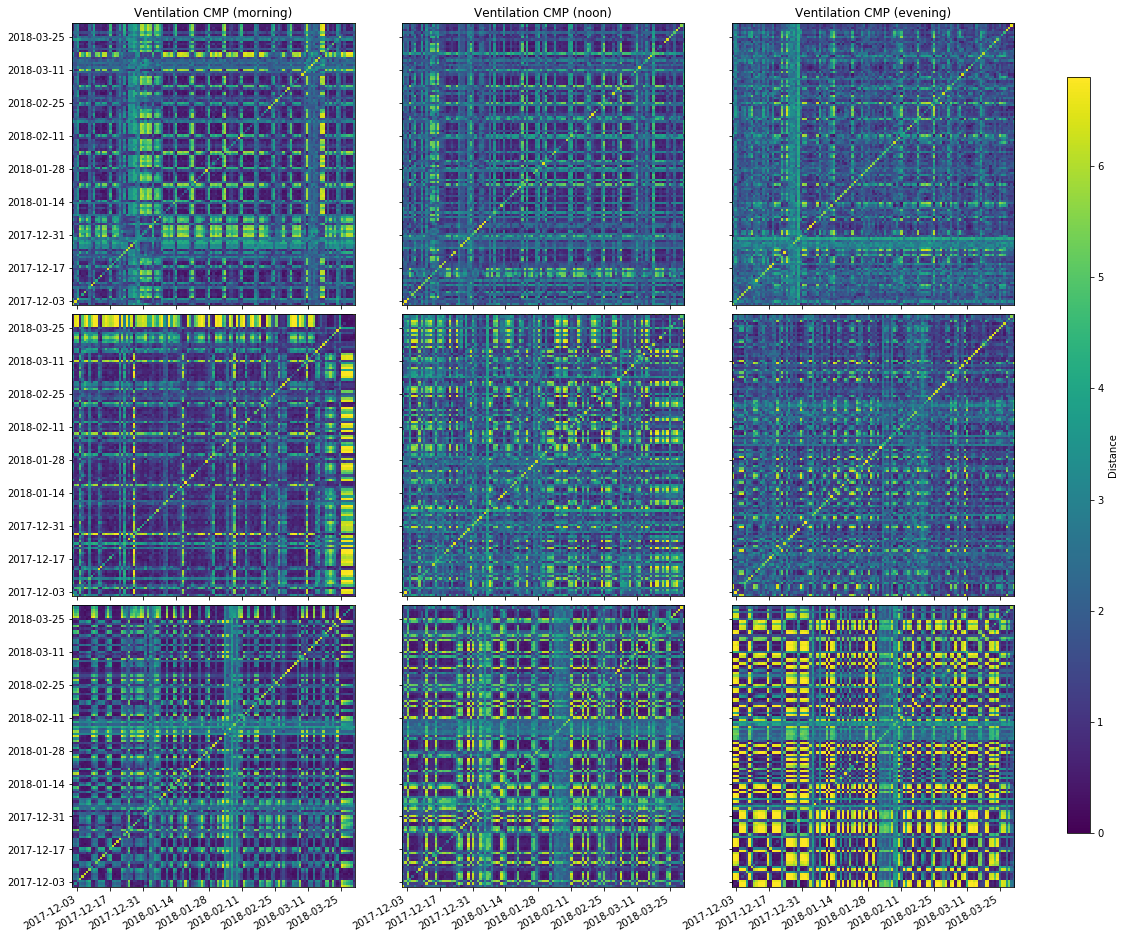

In [9]:
# Plot all CMPs
fig, ax = plt.subplots(3,3, figsize=(16,15), sharex=True, sharey=True)
fig.autofmt_xdate()

date_labels = mdates.date2num(data_days)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]

for i in range(3):
    im = ax[i, 0].imshow(cmps_morning[i].distance_matrix, cmap="viridis", vmin=0, vmax=6.8, extent=extents, origin="lower")
    im = ax[i, 1].imshow(cmps_noon[i].distance_matrix, cmap="viridis", vmin=0, vmax=6.8, extent=extents, origin="lower")
    im = ax[i, 2].imshow(cmps_evening[i].distance_matrix, cmap="viridis", vmin=0, vmax=6.8, extent=extents, origin="lower")

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.95,
                    wspace=0.03, hspace=0.03)
cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Distance")

ax[2,2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'),)
ax[2,2].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[2,2].xaxis.set_major_locator(mticker.MultipleLocator(14))
ax[2,2].yaxis.set_major_locator(mticker.MultipleLocator(14))

ax[0,0].set_title("Ventilation CMP (morning)")
ax[0,1].set_title("Ventilation CMP (noon)")
ax[0,2].set_title("Ventilation CMP (evening)")

Text(0.5, 1.0, 'Ventilation CMP (Unit 3)')

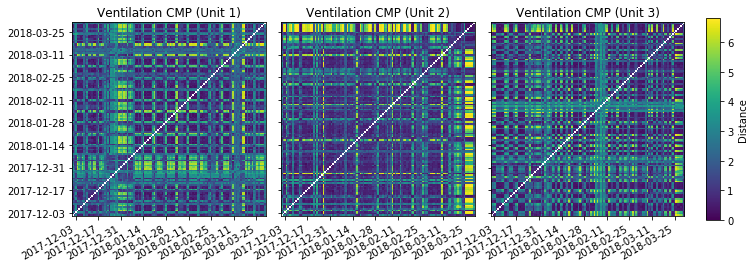

In [10]:
# Plot for only the the morning of all units.
fig, ax = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
fig.autofmt_xdate()

date_labels = mdates.date2num(data_days)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]

for i in range(3):
    im = ax[i].imshow(nan_diag(cmps_morning[i].distance_matrix), cmap="viridis", vmin=0, vmax=6.8, extent=extents, origin="lower")

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.95,
                    wspace=0.08, hspace=0.03)
cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Distance")

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'),)
ax[0].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mticker.MultipleLocator(14))
ax[0].yaxis.set_major_locator(mticker.MultipleLocator(14))

ax[0].set_title("Ventilation CMP (Unit 1)")
ax[1].set_title("Ventilation CMP (Unit 2)")
ax[2].set_title("Ventilation CMP (Unit 3)")

# plt.savefig("ventilation_exploration_mornings.pdf", dpi=300, bbox_inches='tight')

Top weekend anomalies:
Saturday 2018-03-31
Sunday 2018-03-25
Saturday 2018-01-13
Saturday 2018-02-17
Saturday 2018-03-24
Saturday 2018-03-10


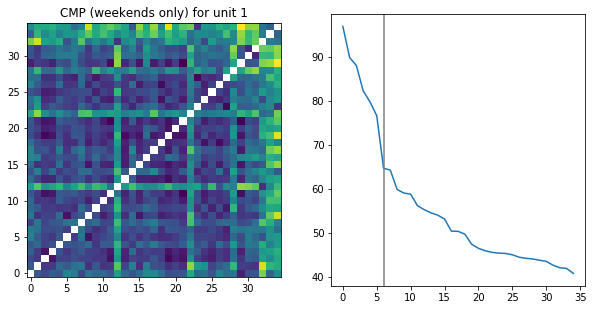

In [11]:
# Left: Plot the CMP for weekends only
# Right: Sorted anomaly scores (anomaly score for 1 day is the summed row of the CMP) with anomaly threshold
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(nan_diag(cmps_morning[0].distance_matrix[weekends, :][:, weekends]), cmap="viridis", origin="lower")
ax[0].set_title("CMP (weekends only) for unit 1")


summed_dists = nan_diag(cmps_morning[0].distance_matrix[weekends, :][:, weekends])
summed_dists = np.nansum(summed_dists, axis=1)
ax[1].plot(np.sort(summed_dists)[::-1])
ax[1].axvline(6, c="gray")

anomaly_order = np.argsort(summed_dists)[::-1]
print("Top weekend anomalies:")
for i in range(6):
    day = data_days[weekends][anomaly_order[i]]
    print(day.day_name(), str(day)[:10])

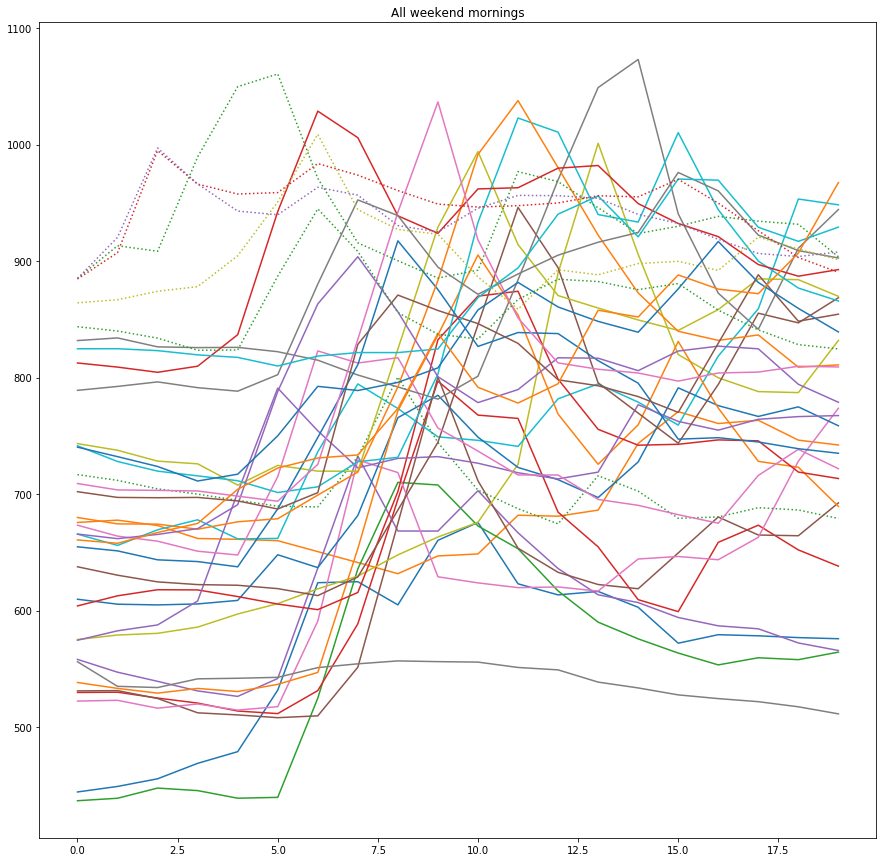

In [12]:
# Plot of all mornings in the weekend, anomalies are in dotted line.
# It is quite hard to find an intuitive visualization this way.
plt.figure(figsize=(15,15))
plt.title("All weekend mornings")

daily_data = data[0].values.reshape((-1, 4*24))
_6am = 24
_8am = 32

for i in range(0, 35):
    ls = "-"
    if np.sum(cmps_morning[0].distance_matrix[weekends, :][:, weekends], axis=1)[i] > 70:
        ls=":"
    plt.plot(10*i + daily_data[weekends,:][i, _6am:_8am + m], ls=ls)

Top weekday anomalies:
Tuesday 2018-01-02
Monday 2018-01-01
Wednesday 2018-01-03
Wednesday 2017-12-27
Thursday 2017-12-28
Friday 2018-01-05
Monday 2017-12-25
Tuesday 2017-12-26
Friday 2017-12-29
Thursday 2017-12-21
Monday 2018-01-08
Monday 2018-03-12
Wednesday 2018-03-14
Friday 2017-12-08
Thursday 2018-03-15


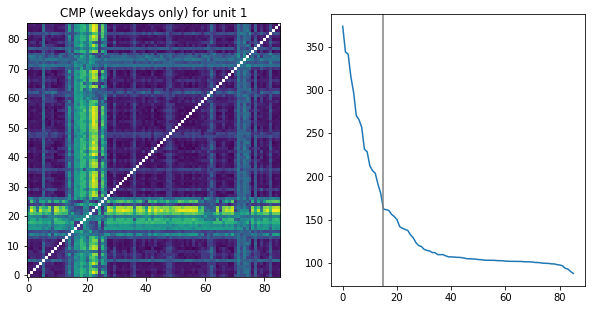

In [13]:
# Left: Plot the CMP for weekdays only
# Right: Sorted anomaly scores (anomaly score for 1 day is the summed row of the CMP) with anomaly threshold
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(nan_diag(cmps_morning[0].distance_matrix[weekdays, :][:, weekdays]), cmap="viridis", origin="lower")
ax[0].set_title("CMP (weekdays only) for unit 1")


summed_dists = cmps_morning[0].distance_matrix[weekdays, :][:, weekdays].copy()
summed_dists[np.diag_indices(len(summed_dists))] = 0
summed_dists = np.sum(summed_dists, axis=1)
ax[1].plot(np.sort(summed_dists)[::-1])
ax[1].axvline(15, c="gray")

anomaly_order = np.argsort(summed_dists)[::-1]
print("Top weekday anomalies:")
for i in range(15):
    day = data_days[weekdays][anomaly_order[i]]
    print(day.day_name(), str(day)[:10])

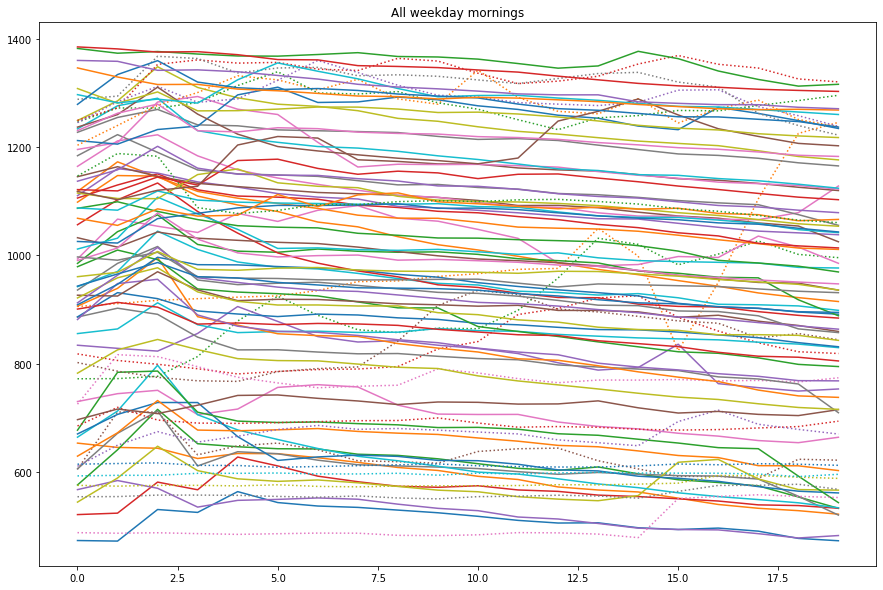

In [14]:
# Plot of all mornings in the weekdays, anomalies are in dotted line
plt.figure(figsize=(15,10))
plt.title("All weekday mornings")

daily_data = data[0].values.reshape((-1, 4*24))
_6am = 24
_8am = 32

for i in range(0, 85):
    ls = "-"
    if np.sum(cmps_morning[0].distance_matrix[weekdays, :][:, weekdays], axis=1)[i] > 160:
        ls=":"
    plt.plot(10*i + daily_data[weekdays,:][i, _6am:_8am + m], ls=ls)

Displayed days are:
Sunday 2017-12-17 00:00:00
Sunday 2017-12-24 00:00:00
Saturday 2018-01-06 00:00:00
Sunday 2018-01-14 00:00:00
Sunday 2018-01-28 00:00:00
Saturday 2018-02-10 00:00:00
Sunday 2018-02-18 00:00:00
Saturday 2018-01-13 00:00:00
Saturday 2018-02-17 00:00:00
Saturday 2018-03-31 00:00:00


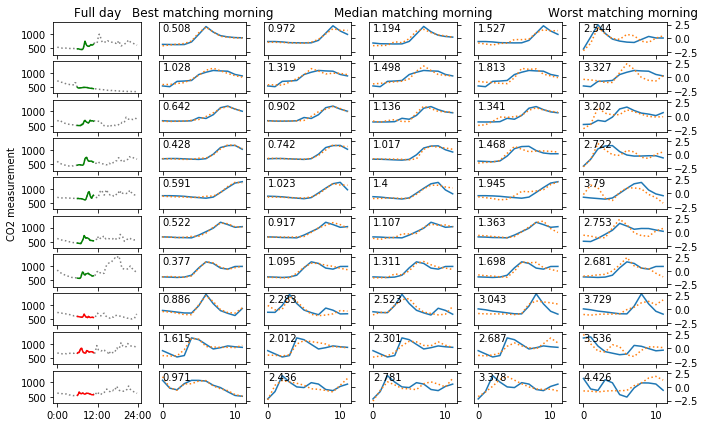

In [15]:
# Matching Table for selected weekend days
# Each row corresponds to one weekend day with the morning context highlighted in the leftmost column.
# The next 5 columns show the different matches to all other weekend days, from best to worst.
# Note that the matches allow a timeshift of 2 hours for the matching (as defined by the contexts).
# The number shown corresponds to the ZNormed Euclidean distance between both displayed fragments.
# Green for "normal" behavior, red for "anomalous".

days_to_show = [5, 7, 10, 13, 17, 20, 23, 12, 22, 34]
matches_to_show = 5

raw_data = data[0].values
daily_data = raw_data.reshape((-1, 4*24))
_6am = 24
_8am = 32

anomalous = np.sum(cmps_morning[0].distance_matrix[weekends, :][:, weekends], axis=1) > 70
num_weekends = np.count_nonzero(weekends)
dm_weekend = cmps_morning[0].distance_matrix[weekends, :][:, weekends]
match_series_weekend = cmps_morning[0].match_index_series[weekends, :][:, weekends]
match_query_weekend = cmps_morning[0].match_index_query[weekends, :][:, weekends]

# Only (num_weekends - 1) matches are valid - do not include the self-match
match_idxs = np.linspace(0, num_weekends - 2, matches_to_show).astype(np.int)

fig, ax = plt.subplots(len(days_to_show), matches_to_show + 1, sharex='col', sharey='col', figsize=(11,7))
print("Displayed days are:")

for i, day in enumerate(days_to_show):
    print(data_days[weekends][day].day_name(), str(data_days[weekends][day]))
    
    c = "green"
    if anomalous[day]:
        c = "red"
        
    ax[i, 0].plot(daily_data[weekends, :][day, :], c='gray', ls=":")
    ax[i, 0].plot(range(_6am, _8am+m), daily_data[weekends, :][day, _6am: _8am+m], c=c)
    
    distances = dm_weekend[day, :]
    dist_order = np.argsort(distances)
    
    for j, match_day in enumerate(dist_order[match_idxs]):
        sm = match_series_weekend[match_day, day]
        qm = match_query_weekend[match_day, day]
        
        ax[i, j+1].plot(znorm(raw_data[sm: sm+m]))
        ax[i, j+1].plot(znorm(raw_data[qm: qm+m]), ls=":")
        
        dist = np.sqrt(np.sum(np.square(znorm(raw_data[sm: sm+m]) - znorm(raw_data[qm: qm+m]))))
        ax[i, j+1].text(0, 1.25, np.round(dist, 3))
        

ax[0, 0].set_xticks(range(0, 4*24+1, 12*4))
ticklabels = ["{hour}:00".format(hour=(x // 4)) for x in range(0, 4*24+1, 12*4)]
ax[0, 0].set_xticklabels(ticklabels)

ax[(len(days_to_show)-1)//2, 0].set_ylabel("CO2 measurement")

ax[0, 0].set_title("Full day")
ax[0, 1].set_title("Best matching morning")
ax[0, (1+matches_to_show) // 2].set_title("Median matching morning")
ax[0, matches_to_show].set_title("Worst matching morning")

for r in range(len(days_to_show)):
    for c in range(1, 1+matches_to_show):
        ax[r, c].set_ylim(-2.9, 2.9)
        ax[r, c].yaxis.tick_right()
        
        if c != matches_to_show:
            ax[r, c]. yaxis.set_ticklabels([])

# plt.savefig("ventilation_weekend_details.pdf", dpi=300, bbox_inches='tight')

Displayed days are:
Saturday 2017-12-02 00:00:00
Sunday 2017-12-03 00:00:00
Saturday 2017-12-09 00:00:00
Sunday 2017-12-10 00:00:00
Saturday 2017-12-16 00:00:00
Sunday 2017-12-17 00:00:00
Saturday 2017-12-23 00:00:00
Sunday 2017-12-24 00:00:00
Saturday 2017-12-30 00:00:00
Sunday 2017-12-31 00:00:00
Saturday 2018-01-06 00:00:00
Sunday 2018-01-07 00:00:00
Saturday 2018-01-13 00:00:00
Sunday 2018-01-14 00:00:00
Saturday 2018-01-20 00:00:00
Sunday 2018-01-21 00:00:00
Saturday 2018-01-27 00:00:00
Sunday 2018-01-28 00:00:00
Saturday 2018-02-03 00:00:00
Sunday 2018-02-04 00:00:00
Saturday 2018-02-10 00:00:00
Sunday 2018-02-11 00:00:00
Saturday 2018-02-17 00:00:00
Sunday 2018-02-18 00:00:00
Saturday 2018-02-24 00:00:00
Sunday 2018-02-25 00:00:00
Saturday 2018-03-03 00:00:00
Sunday 2018-03-04 00:00:00
Saturday 2018-03-10 00:00:00
Sunday 2018-03-11 00:00:00
Saturday 2018-03-17 00:00:00
Sunday 2018-03-18 00:00:00
Saturday 2018-03-24 00:00:00
Sunday 2018-03-25 00:00:00
Saturday 2018-03-31 00:00:00

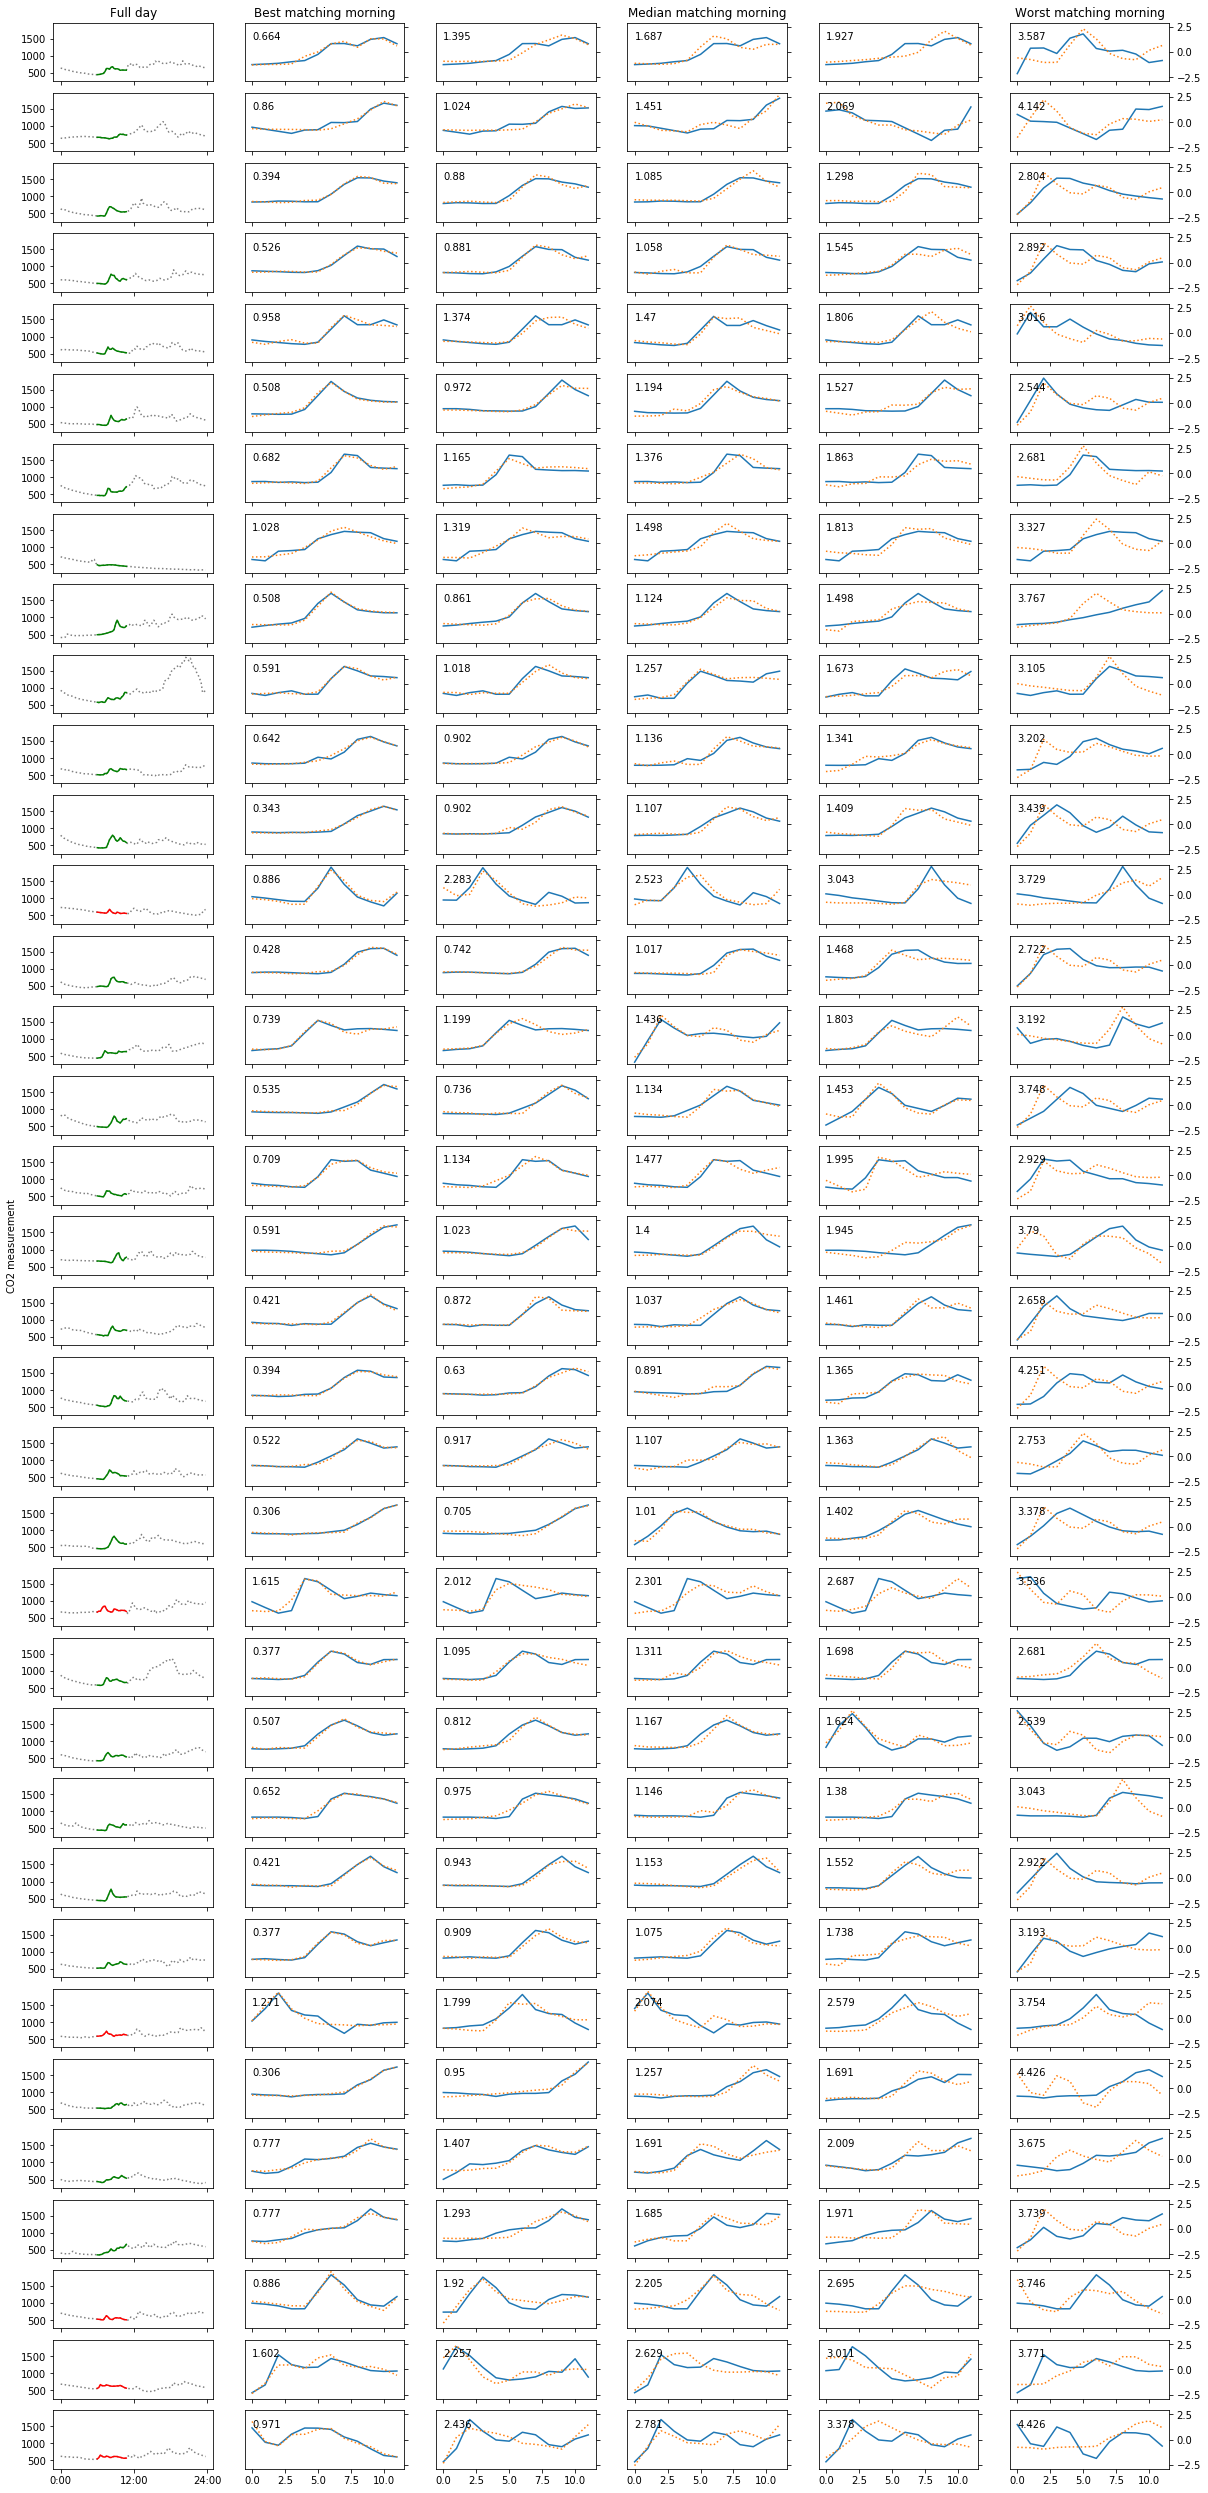

In [16]:
# The same plot, but bigger and containing all weekend days
days_to_show = range(num_weekends)

fig, ax = plt.subplots(len(days_to_show), matches_to_show + 1, sharex='col', sharey='col', figsize=(20,45))
print("Displayed days are:")

for i, day in enumerate(days_to_show):
    print(data_days[weekends][day].day_name(), str(data_days[weekends][day]))
    
    c = "green"
    if anomalous[day]:
        c = "red"
        
    ax[i, 0].plot(daily_data[weekends, :][day, :], c='gray', ls=":")
    ax[i, 0].plot(range(_6am, _8am+m), daily_data[weekends, :][day, _6am: _8am+m], c=c)
    
    distances = dm_weekend[day, :]
    dist_order = np.argsort(distances)
    
    for j, match_day in enumerate(dist_order[match_idxs]):
        sm = match_series_weekend[match_day, day]
        qm = match_query_weekend[match_day, day]
        
        ax[i, j+1].plot(znorm(raw_data[sm: sm+m]))
        ax[i, j+1].plot(znorm(raw_data[qm: qm+m]), ls=":")
        
        dist = np.sqrt(np.sum(np.square(znorm(raw_data[sm: sm+m]) - znorm(raw_data[qm: qm+m]))))
        ax[i, j+1].text(0, 1.25, np.round(dist, 3))
        

ax[0, 0].set_xticks(range(0, 4*24+1, 12*4))
ticklabels = ["{hour}:00".format(hour=(x // 4)) for x in range(0, 4*24+1, 12*4)]
ax[0, 0].set_xticklabels(ticklabels)

ax[(len(days_to_show)-1)//2, 0].set_ylabel("CO2 measurement")

ax[0, 0].set_title("Full day")
ax[0, 1].set_title("Best matching morning")
ax[0, (1+matches_to_show) // 2].set_title("Median matching morning")
ax[0, matches_to_show].set_title("Worst matching morning")

for r in range(len(days_to_show)):
    for c in range(1, 1+matches_to_show):
        ax[r, c].set_ylim(-2.9, 2.9)
        ax[r, c].yaxis.tick_right()
        
        if c != matches_to_show:
            ax[r, c]. yaxis.set_ticklabels([])

Displayed days are:
Friday 2017-12-01 00:00:00
Monday 2017-12-04 00:00:00
Tuesday 2017-12-05 00:00:00
Wednesday 2017-12-06 00:00:00
Thursday 2017-12-07 00:00:00
Friday 2017-12-08 00:00:00
Monday 2017-12-11 00:00:00
Tuesday 2017-12-12 00:00:00
Wednesday 2017-12-13 00:00:00
Thursday 2017-12-14 00:00:00
Friday 2017-12-15 00:00:00
Monday 2017-12-18 00:00:00
Tuesday 2017-12-19 00:00:00
Wednesday 2017-12-20 00:00:00
Thursday 2017-12-21 00:00:00
Friday 2017-12-22 00:00:00
Monday 2017-12-25 00:00:00
Tuesday 2017-12-26 00:00:00
Wednesday 2017-12-27 00:00:00
Thursday 2017-12-28 00:00:00


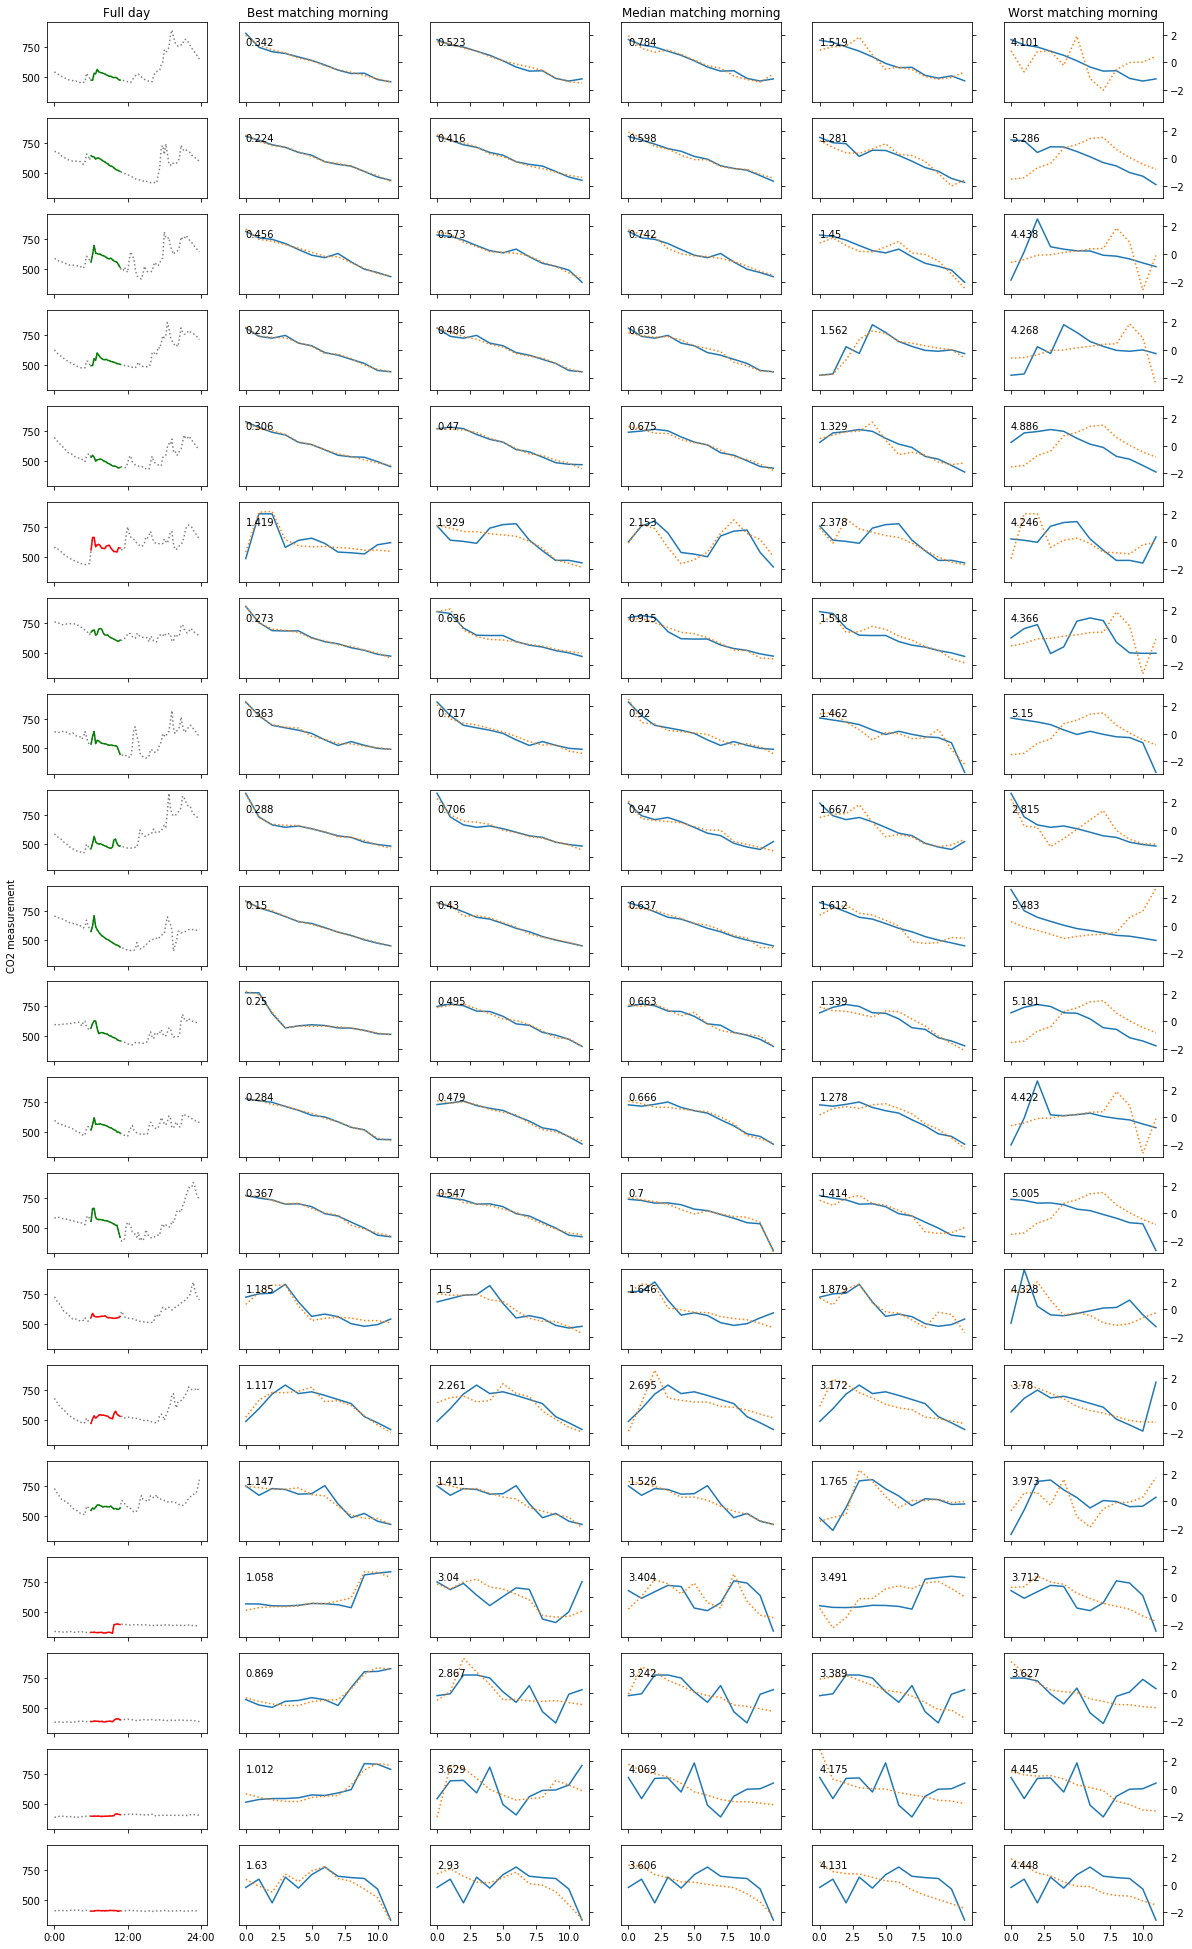

In [17]:
# The same plot, for all weekdays in December

days_to_show = range(20)

anomalous = np.sum(cmps_morning[0].distance_matrix[weekdays, :][:, weekdays], axis=1) > 160

dm_weekday = cmps_morning[0].distance_matrix[weekdays, :][:, weekdays]
match_series_weekday = cmps_morning[0].match_index_series[weekdays, :][:, weekdays]
match_query_weekday = cmps_morning[0].match_index_query[weekdays, :][:, weekdays]
num_weekdays = np.count_nonzero(weekdays)

# Only (num_weekends - 1) matches are valid - do not include the self-match
match_idxs = np.linspace(0, num_weekdays - 2, matches_to_show).astype(np.int)

fig, ax = plt.subplots(len(days_to_show), matches_to_show + 1, sharex='col', sharey='col', figsize=(20,35))
print("Displayed days are:")

for i, day in enumerate(days_to_show):
    print(data_days[weekdays][day].day_name(), str(data_days[weekdays][day]))
    
    c = "green"
    if anomalous[day]:
        c = "red"
        
    ax[i, 0].plot(daily_data[weekdays, :][day, :], c='gray', ls=":")
    ax[i, 0].plot(range(_6am, _8am+m), daily_data[weekdays, :][day, _6am: _8am+m], c=c)
    
    distances = dm_weekday[day, :]
    dist_order = np.argsort(distances)
    
    for j, match_day in enumerate(dist_order[match_idxs]):
        sm = match_series_weekday[match_day, day]
        qm = match_query_weekday[match_day, day]
        
        ax[i, j+1].plot(znorm(raw_data[sm: sm+m]))
        ax[i, j+1].plot(znorm(raw_data[qm: qm+m]), ls=":")
        
        dist = np.sqrt(np.sum(np.square(znorm(raw_data[sm: sm+m]) - znorm(raw_data[qm: qm+m]))))
        ax[i, j+1].text(0, 1.25, np.round(dist, 3))
        

ax[0, 0].set_xticks(range(0, 4*24+1, 12*4))
ticklabels = ["{hour}:00".format(hour=(x // 4)) for x in range(0, 4*24+1, 12*4)]
ax[0, 0].set_xticklabels(ticklabels)

ax[(len(days_to_show)-1)//2, 0].set_ylabel("CO2 measurement")

ax[0, 0].set_title("Full day")
ax[0, 1].set_title("Best matching morning")
ax[0, (1+matches_to_show) // 2].set_title("Median matching morning")
ax[0, matches_to_show].set_title("Worst matching morning")

for r in range(len(days_to_show)):
    for c in range(1, 1+matches_to_show):
        ax[r, c].set_ylim(-2.9, 2.9)
        ax[r, c].yaxis.tick_right()
        
        if c != matches_to_show:
            ax[r, c]. yaxis.set_ticklabels([])
